In [5]:
# Cell 1: Imports and setup (unchanged)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# plotting
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

In [6]:
# Cell 2: VADER setup (unchanged)
# Download VADER lexicon if needed (run once)
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords

sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Cell 3: Create a synthetic dataset of bank app reviews (unchanged)
data = [
    {"review_id":1,"bank_code":"CBE","bank_name":"Commercial Bank","review_text":"Exceptional product, very easy to use and fast.","rating":5},
    {"review_id":2,"bank_code":"BOA","bank_name":"Bank of Abyssinia","review_text":"The app is impressive and smooth. Great job Dashen Bank!","rating":5},
    {"review_id":3,"bank_code":"CBE","bank_name":"Commercial Bank","review_text":"Good app but sometimes it is slow.","rating":3},
    {"review_id":4,"bank_code":"BOA","bank_name":"Bank of Abyssinia","review_text":"Bill payment options are limited, please add more services.","rating":2},
    {"review_id":5,"bank_code":"Dashen","bank_name":"Dashen Bank","review_text":"It is really slow and always crashing. Very frustrating!","rating":1},
    {"review_id":6,"bank_code":"Dashen","bank_name":"Dashen Bank","review_text":"Always updating, bad stability, I don't like it.","rating":1},
    {"review_id":7,"bank_code":"CBE","bank_name":"Commercial Bank","review_text":"With the super app everything I need is just a tap away.","rating":5},
    {"review_id":8,"bank_code":"BOA","bank_name":"Bank of Abyssinia","review_text":"It's okay, nothing special but it works.","rating":3},
    {"review_id":9,"bank_code":"Dashen","bank_name":"Dashen Bank","review_text":"I disabled developer options but it still doesn't work.","rating":1},
    {"review_id":10,"bank_code":"CBE","bank_name":"Commercial Bank","review_text":"Clean design, user friendly and reliable.","rating":4},
]

df = pd.DataFrame(data)
df.head()

,review_id,bank_code,bank_name,review_text,rating
0,1,CBE,Commercial Bank,"Exceptional product, very easy to use and fast.",5
1,2,BOA,Bank of Abyssinia,The app is impressive and smooth. Great job Da...,5
2,3,CBE,Commercial Bank,Good app but sometimes it is slow.,3
3,4,BOA,Bank of Abyssinia,"Bill payment options are limited, please add m...",2
4,5,Dashen,Dashen Bank,It is really slow and always crashing. Very fr...,1


In [8]:
# Cell 4: Convert star rating to sentiment label (baseline)
def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["rating_label"] = df["rating"].apply(rating_to_label)
df.head()

,review_id,bank_code,bank_name,review_text,rating,rating_label
0,1,CBE,Commercial Bank,"Exceptional product, very easy to use and fast.",5,positive
1,2,BOA,Bank of Abyssinia,The app is impressive and smooth. Great job Da...,5,positive
2,3,CBE,Commercial Bank,Good app but sometimes it is slow.,3,neutral
3,4,BOA,Bank of Abyssinia,"Bill payment options are limited, please add m...",2,negative
4,5,Dashen,Dashen Bank,It is really slow and always crashing. Very fr...,1,negative


In [9]:
# Cell 5: Simple preprocessing - lowercase (already in your flow)
df["clean_text"] = df["review_text"].str.lower()
df[["review_text","clean_text"]].head()

,review_text,clean_text
0,"Exceptional product, very easy to use and fast.","exceptional product, very easy to use and fast."
1,The app is impressive and smooth. Great job Da...,the app is impressive and smooth. great job da...
2,Good app but sometimes it is slow.,good app but sometimes it is slow.
3,"Bill payment options are limited, please add m...","bill payment options are limited, please add m..."
4,It is really slow and always crashing. Very fr...,it is really slow and always crashing. very fr...


In [10]:
# Cell 6: TextBlob sentiment (polarity & subjectivity + label)
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)
df[["review_text","tb_polarity","tb_subjectivity","tb_sentiment"]]

,review_text,tb_polarity,tb_subjectivity,tb_sentiment
0,"Exceptional product, very easy to use and fast.",0.476667,0.866667,positive
1,The app is impressive and smooth. Great job Da...,0.800000,0.750000,positive
2,Good app but sometimes it is slow.,0.200000,0.500000,positive
3,"Bill payment options are limited, please add m...",0.214286,0.321429,positive
4,It is really slow and always crashing. Very fr...,-0.475000,0.700000,negative
5,"Always updating, bad stability, I don't like it.",-0.700000,0.666667,negative
6,With the super app everything I need is just a...,0.333333,0.666667,positive
7,"It's okay, nothing special but it works.",0.428571,0.535714,positive
8,I disabled developer options but it still does...,-0.200000,0.300000,negative
9,"Clean design, user friendly and reliable.",0.370833,0.600000,positive


In [11]:
# Cell 7: VADER sentiment (compound + label)
def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

df["vader_compound"] = df["review_text"].apply(vader_compound)

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)
df[["review_text","vader_compound","vader_sentiment"]]

,review_text,vader_compound,vader_sentiment
0,"Exceptional product, very easy to use and fast.",0.4927,positive
1,The app is impressive and smooth. Great job Da...,0.8268,positive
2,Good app but sometimes it is slow.,0.2382,positive
3,"Bill payment options are limited, please add m...",0.1027,positive
4,It is really slow and always crashing. Very fr...,-0.5400,negative
5,"Always updating, bad stability, I don't like it.",-0.6818,negative
6,With the super app everything I need is just a...,0.5994,positive
7,"It's okay, nothing special but it works.",-0.0462,neutral
8,I disabled developer options but it still does...,0.0000,neutral
9,"Clean design, user friendly and reliable.",0.7096,positive


In [12]:
# Cell 8: (Optional) DistilBERT placeholder - only if you install transformers
# NOTE: this cell is optional. If you don't want to install transformers / torch, skip it.
"""
from transformers import pipeline
distilbert_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
def classify_distilbert(text):
    try:
        r = distilbert_classifier(text[:512])[0]
        label = r["label"].lower()
        score = r["score"]
        if score < 0.6: return "neutral", score
        return label, score
    except:
        return "neutral", 0.5

df[["distilbert_sentiment","distilbert_score"]] = zip(*df["review_text"].apply(classify_distilbert))
df[["review_text","distilbert_sentiment","distilbert_score"]]
"""
print("DistilBERT cell left optional — run if you install transformers.")

DistilBERT cell left optional — run if you install transformers.


In [13]:
# Cell 9: Aggregate sentiment by bank and rating (TextBlob + VADER)
agg = df.groupby(["bank_code","rating"]).agg(
    count_reviews=("review_id","count"),
    avg_tb_polarity=("tb_polarity","mean"),
    avg_vader_compound=("vader_compound","mean")
).reset_index()

agg

,bank_code,rating,count_reviews,avg_tb_polarity,avg_vader_compound
0,BOA,2,1,0.214286,0.102700
1,BOA,3,1,0.428571,-0.046200
2,BOA,5,1,0.800000,0.826800
3,CBE,3,1,0.200000,0.238200
4,CBE,4,1,0.370833,0.709600
5,CBE,5,2,0.405000,0.546050
6,Dashen,1,3,-0.458333,-0.407267


In [14]:
# Cell 10: Word frequency (CountVectorizer) and TF-IDF (you already have similar code)
count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word":vocab,"count":word_counts}).sort_values("count",ascending=False)
freq_df.head(10)

,word,count
1,app,3
27,options,2
33,slow,2
0,add,1
4,bank,1
5,clean,1
6,crashing,1
7,dashen,1
8,design,1
9,developer,1


In [15]:
# Cell 11: TF-IDF representation (top words)
tfidf_vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=200)
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word":vocab_tfidf,"tfidf":tfidf_means}).sort_values("tfidf",ascending=False)
tfidf_df.head(20)

,word,tfidf
2,app,0.079853
62,slow,0.073897
51,options,0.057567
35,good app,0.048361
34,good,0.048361
5,app slow,0.048361
67,special works,0.044721
49,okay,0.044721
50,okay special,0.044721
66,special,0.044721


In [16]:
# Cell 12: Theme keyword buckets (rule-based grouping)
# Define simple theme buckets and keywords for grouping (customize as you like)
theme_keywords = {
    "User Interface & UX": ["design","interface","ui","user","clean","friendly","ux"],
    "Performance & Reliability": ["slow","crash","crashing","stability","lag","slowly","speed","crash"],
    "Payments & Transactions": ["payment","bill","transfer","pay","transaction","payments","billing"],
    "Customer Support": ["support","help","customer","service","agent"],
    "Features & Options": ["feature","option","features","options","service","services"]
}

In [17]:
# Cell 13: Extract top TF-IDF keywords per bank and map to themes automatically
top_n = 15
bank_keywords = {}

feature_names = tfidf_vec.get_feature_names_out()
for bank, group in df.groupby("bank_code"):
    # build tfidf on group (small groups ok)
    vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=200)
    X = vec.fit_transform(group["clean_text"])
    names = vec.get_feature_names_out()
    scores = np.asarray(X.sum(axis=0)).flatten()
    kdf = pd.DataFrame({"word":names,"score":scores}).sort_values("score",ascending=False)
    bank_keywords[bank] = kdf["word"].head(top_n).tolist()

# Map keywords to themes per bank using simple keyword matching
bank_themes = {}
for bank, keywords in bank_keywords.items():
    theme_counts = {}
    examples = {}
    for theme, keys in theme_keywords.items():
        matches = [kw for kw in keywords for k in keys if k in kw.lower()]
        if matches:
            theme_counts[theme] = len(matches)
            examples[theme] = matches[:5]
    # pick top 3 themes by matches (or fewer)
    sorted_themes = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
    selected = [t for t,_ in sorted_themes][:3]
    # include example keywords for context
    bank_themes[bank] = {t: examples.get(t,[]) for t in selected}

# Show results
for bank, themes in bank_themes.items():
    print(f"\nBank {bank} themes:")
    if themes:
        for t,ex in themes.items():
            print(f" - {t}: examples -> {ex}")
    else:
        print(" - No strong theme matches found; consider manual inspection.")


Bank BOA themes:
 - Features & Options: examples -> ['options', 'options', 'add services', 'add services', 'payment options']
 - Payments & Transactions: examples -> ['payment options', 'payment options', 'payment', 'payment']
 - Customer Support: examples -> ['add services', 'services']

Bank CBE themes:
 - User Interface & UX: examples -> ['design user', 'design user', 'design', 'clean', 'friendly reliable']
 - Performance & Reliability: examples -> ['app slow', 'slow']

Bank Dashen themes:
 - Performance & Reliability: examples -> ['crashing', 'crashing', 'crashing', 'crashing frustrating', 'crashing frustrating']
 - Features & Options: examples -> ['developer options', 'developer options']


In [18]:
# Cell 14: Assign themes back to rows (simple approach: attach bank-level themes)
def assign_themes_to_row(bank_code):
    themes = list(bank_themes.get(bank_code, {}).keys())
    return themes if themes else ["Other"]

df["identified_themes"] = df["bank_code"].apply(assign_themes_to_row)
df[["review_id","bank_code","review_text","identified_themes"]]

,review_id,bank_code,review_text,identified_themes
0,1,CBE,"Exceptional product, very easy to use and fast.","[User Interface & UX, Performance & Reliability]"
1,2,BOA,The app is impressive and smooth. Great job Da...,"[Features & Options, Payments & Transactions, ..."
2,3,CBE,Good app but sometimes it is slow.,"[User Interface & UX, Performance & Reliability]"
3,4,BOA,"Bill payment options are limited, please add m...","[Features & Options, Payments & Transactions, ..."
4,5,Dashen,It is really slow and always crashing. Very fr...,"[Performance & Reliability, Features & Options]"
5,6,Dashen,"Always updating, bad stability, I don't like it.","[Performance & Reliability, Features & Options]"
6,7,CBE,With the super app everything I need is just a...,"[User Interface & UX, Performance & Reliability]"
7,8,BOA,"It's okay, nothing special but it works.","[Features & Options, Payments & Transactions, ..."
8,9,Dashen,I disabled developer options but it still does...,"[Performance & Reliability, Features & Options]"
9,10,CBE,"Clean design, user friendly and reliable.","[User Interface & UX, Performance & Reliability]"


In [19]:
# Cell 15: Coverage KPI and save results
# Coverage: proportion of reviews that have a non-empty sentiment (TextBlob & VADER both always produce scores here)
df["has_tb"] = ~df["tb_polarity"].isna()
df["has_vader"] = ~df["vader_compound"].isna()

coverage_tb = df["has_tb"].mean() * 100
coverage_vader = df["has_vader"].mean() * 100

print(f"Coverage: TextBlob: {coverage_tb:.1f}%, VADER: {coverage_vader:.1f}%")

# Save final CSV with relevant columns
out_cols = ["review_id","bank_code","bank_name","review_text","rating",
            "rating_label","tb_polarity","tb_subjectivity","tb_sentiment",
            "vader_compound","vader_sentiment","identified_themes"]

df.to_csv("reviews_sentiment_themes.csv", columns=out_cols, index=False)
print("Saved reviews_sentiment_themes.csv")

Coverage: TextBlob: 100.0%, VADER: 100.0%
Saved reviews_sentiment_themes.csv


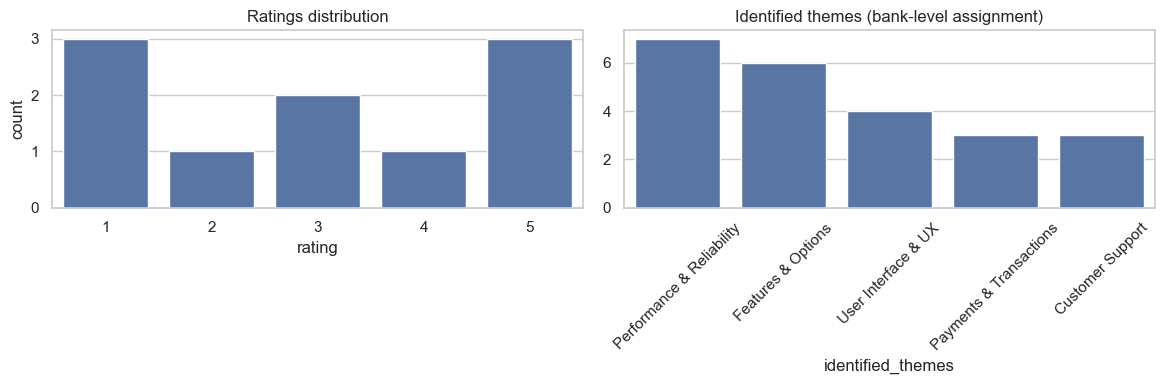

In [20]:
# Cell 16: Quick visual checks (ratings distribution + top themes counts)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x="rating", data=df)
plt.title("Ratings distribution")

plt.subplot(1,2,2)
# flatten themes to count occurrences
theme_rows = df.explode("identified_themes")["identified_themes"].value_counts()
sns.barplot(x=theme_rows.index, y=theme_rows.values)
plt.xticks(rotation=45)
plt.title("Identified themes (bank-level assignment)")
plt.tight_layout()
plt.show()